# Does Social Pressure Influence Voting Behavior?

### Key Takeaways: ###

- **Social pressure involving peers, specifically neighbors, positively influences one's tendency to vote.**

- **Our logistic model performed in-line with our baseline model.**

- **Our CART models provided us with the in formation we needed to determine the relationships among the variables and differing voting probabilities within each group.**

- **We demonstrated that CART models inherently capture non-linear interactions among variables missed by linear models. Furthermore, we illustrated how interaction terms can be added to logistic models to incorporate non-linear relationships.**

### The Study ###
"In August 2006 three researchers (Alan Gerber and Donald Green of Yale University, and Christopher Larimer of the University of Northern Iowa) carried out a large scale field experiment in Michigan, USA to test the hypothesis that one of the reasons people vote is social, or extrinsic, pressure."

(source: MITx)

### The Data ###

"The researchers grouped about 344,000 voters into different groups randomly - about 191,000 voters were a "control" group, and the rest were categorized into one of four "treatment" groups. These five groups correspond to five binary variables in the dataset." Two demographic variables were also collected, along with the binary response variable, "voting."

**civicduty**: group members were sent a note saying "DO YOUR CIVIC DUTY - VOTE!"

**hawthorne**: group members were sent the "Civic Duty" message plus the message "YOU ARE BEING STUDIED" and told their voting behavior would be examined via public records.

**self**: group members were sent a revised "Civic Duty" message, in addition to recent voting records for everyone in their home. The revision stated that updated voting records for the household would be sent after the election.

**neighbors**: group members received the same message as the "Self" group, accompanied by not only voting records for the household, but also those of neighbors. This was done to maximize social pressure.

**control**: group members represented the typical voter.

**sex**: 0 for male, 1 for female 

**yob**: year of birth 

**voting**: 1 if they voted, 0 otherwise

(source: MITx)

In [133]:
gerber = read.csv("gerber.csv")

### Data Structure ###

In [134]:
str(gerber)

'data.frame':	344084 obs. of  8 variables:
 $ sex      : int  0 1 1 1 0 1 0 0 1 0 ...
 $ yob      : int  1941 1947 1982 1950 1951 1959 1956 1981 1968 1967 ...
 $ voting   : int  0 0 1 1 1 1 1 0 0 0 ...
 $ hawthorne: int  0 0 1 1 1 0 0 0 0 0 ...
 $ civicduty: int  1 1 0 0 0 0 0 0 0 0 ...
 $ neighbors: int  0 0 0 0 0 0 0 0 0 0 ...
 $ self     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ control  : int  0 0 0 0 0 1 1 1 1 1 ...


### Data Summary ###

In [135]:
summary(gerber)

      sex              yob           voting         hawthorne    
 Min.   :0.0000   Min.   :1900   Min.   :0.0000   Min.   :0.000  
 1st Qu.:0.0000   1st Qu.:1947   1st Qu.:0.0000   1st Qu.:0.000  
 Median :0.0000   Median :1956   Median :0.0000   Median :0.000  
 Mean   :0.4993   Mean   :1956   Mean   :0.3159   Mean   :0.111  
 3rd Qu.:1.0000   3rd Qu.:1965   3rd Qu.:1.0000   3rd Qu.:0.000  
 Max.   :1.0000   Max.   :1986   Max.   :1.0000   Max.   :1.000  
   civicduty        neighbors          self           control      
 Min.   :0.0000   Min.   :0.000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :0.000   Median :0.0000   Median :1.0000  
 Mean   :0.1111   Mean   :0.111   Mean   :0.1111   Mean   :0.5558  
 3rd Qu.:0.0000   3rd Qu.:0.000   3rd Qu.:0.0000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.000   Max.   :1.0000   Max.   :1.0000  

### Exploratory Data Analysis ###

In [255]:
install.packages("tidyverse")
install.packages("remotes")
install.packages("caTools")
install.packages("ROCR")
install.packages('rpart.plot')
install_github("randy3k/collections")
library(tidyverse)
library(remotes)
library(ROCR)
library(caTools)
library(rpart)
library(rpart.plot)
library(collections)


Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Skipping install of 'collections' from a github remote, the SHA1 (117fff45) has not changed since last install.
  Use `force = TRUE` to force installation
Loading required package: gplots
Warning message:
“package ‘gplots’ was built under R version 3.6.1”
Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [139]:
voting_mean = mean(gerber$voting)
cat(paste(round(voting_mean,4)*100,"% of individuals in the data set voted.", sep=""))

31.59% of individuals in the data set voted.

This begs the question: Which treatment group voted the most?

In [140]:
cols = names(gerber)
groups = cols[4:8]

The chart below indicates the largest percentage of study participants who voted were in the "neighbors" cohort. This suggests heightened social pressure may increase one's propensity to vote.  

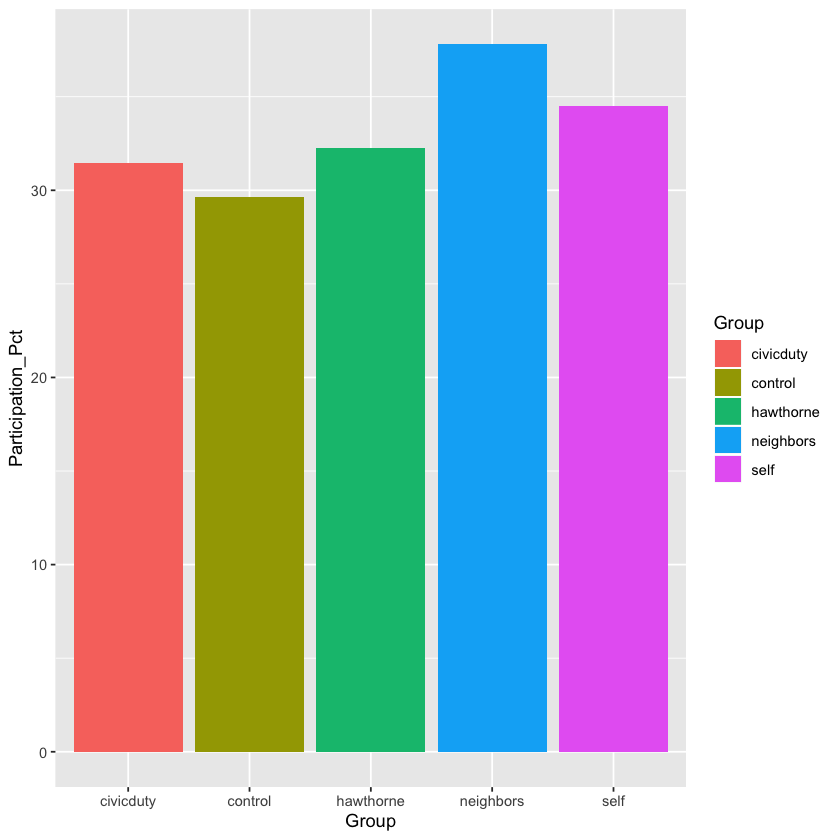

In [141]:
voting_pct = function (groups) {
    
    percents = OrderedDict$new()
    
    for (i in groups) {
        
        percent = round((tapply(gerber$voting, gerber[i], mean)[[2]]),4)*100
        
        percents$set(i,percent)
    }
    
    return(percents)
}

voter_participation=voting_pct(groups)
voter_participation= as.data.frame(voter_participation$as_list())
voter_participation %>% 
  gather(Group,Participation_Pct) %>% 
  ggplot(aes(Group,Participation_Pct,fill=Group))+geom_col()

### The Models ###

####  Logistic Regression ####

Assessing the accuracy of any model begins with a baseline prediction. We use the most frequently observed outcome in the response vecctor as our base prediction. The table below indicates we start with a predicted value of 0 (i.e., not voting) for all respondents and that we are correct approximately 68% of the time.

In [272]:
round(prop.table(table(gerber$voting)),4)*100


    0     1 
68.41 31.59 

We start by examining a logistic regression model using the response vector conditioned on our four treatment groups: civicduty, hawthorne, self, neighbors. The coefficients for all four groups are significant at the .001 level. In light of the participation rates above, this is unexpected. For those expecting us to begin with a training and test split, know that 1) this procedure was performed, 2) the results were exactly the same, and 3) the process was omitted here for ease of exposition.

In [273]:
logit1 = glm(voting ~ civicduty + hawthorne + self + neighbors, data=gerber, family=binomial)

Below we present model construction and summary data. Note that all four treatment groups are highly significant.

In [274]:
summary(logit1)


Call:
glm(formula = voting ~ civicduty + hawthorne + self + neighbors, 
    family = binomial, data = gerber)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9744  -0.8691  -0.8389   1.4586   1.5590  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.863358   0.005006 -172.459  < 2e-16 ***
civicduty    0.084368   0.012100    6.972 3.12e-12 ***
hawthorne    0.120477   0.012037   10.009  < 2e-16 ***
self         0.222937   0.011867   18.786  < 2e-16 ***
neighbors    0.365092   0.011679   31.260  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 429238  on 344083  degrees of freedom
Residual deviance: 428090  on 344079  degrees of freedom
AIC: 428100

Number of Fisher Scoring iterations: 4


Here, we test our model's accuracy by making predictions over the data set and comparing predicted values to observed values.  

In [263]:
predictLogit1 = predict(logit1, type="response")

Rather than repeatedly typing commonly commands commonly used in the analysis of logistic regression models, we developed two helper functions to make the process a bit easier.

In [175]:
confusion_mtx = function(df, observed_y, predicted_y, threshold) {
    
    # Input: dataframe, response variable name as string, vector of 
    # predicted values, threshold value
    # 
    # Output: Confusion matrix to assess model performance
    
    mtx=table(df[[observed_y]], predicted_y > threshold)
    
    return (mtx)
}

In [265]:
confusion_accuracy = function(confusion_matrix) {
    
    # Input: confusion matrix
    #
    # Output: Message stating the accuracy of the model based on the data
    # contained in the matrix.
    
    accuracy = sum(diag(prop.table(confusion_matrix)))
    
    return (cat(paste("Based on the confusion matrix, the accuracy of the model is ", round(accuracy,4)*100, "%", sep="")))
}

The results below are disappointing. Our model underperforms the baseline at a threshold of .30 with an accuracy rate of 54.2%. Raising the threshold to .5 brings our accuracy rate in-line with our benchmark of 68.4%, but offers no advantage. Turning to the ROC curve, we discover the AUC is a paltry .5308, which suggests the preictive value of our model is little better than a coin toss. All things considered, this is an extremely weak model, despite confirmation that subject inclusion in treatment groups is statistically significant. 

In [267]:
cmtx = confusion_mtx(gerber, 'voting', predictLogit1, .3)
confusion_accuracy(cmtx)

Based on the confusion matrix, the accuracy of the model is 54.2%

In [268]:
cmtx = confusion_mtx(gerber, 'voting', predictLogit1, .5)
confusion_accuracy(cmtx)

Based on the confusion matrix, the accuracy of the model is 68.41%

In [276]:
ROCRpred = prediction(predictLogit1, gerber$voting)
cat(paste(round(as.numeric(performance(ROCRpred, "auc")@y.values),4), sep=""))

0.5308

#### The CART Model ####

The above results suggest we would be wise to expand our hypothesis set to include another type of model. A CART model can split treatment groups based on their probability of voting, so we will abandon our logistic model and adopt a tree-based approach.

In [279]:
cart_1 = rpart(voting ~ civicduty + hawthorne + self + neighbors, data=gerber, cp=0.0)

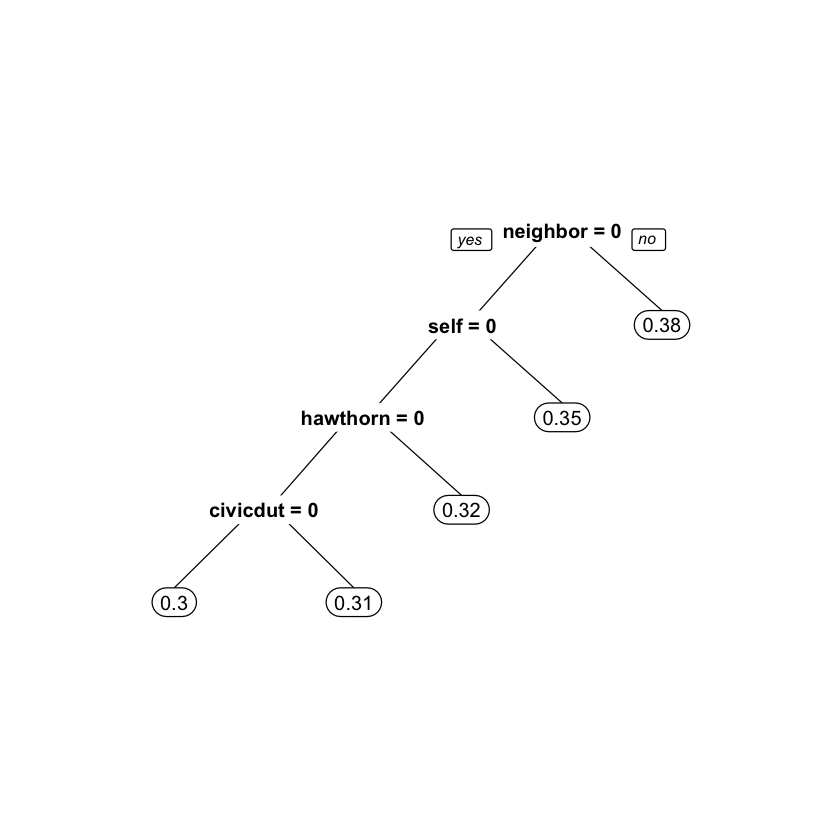

In [280]:
prp(cart_1)

In [281]:
cart_2 = rpart(voting ~ sex + civicduty + hawthorne + self + neighbors, data=train, cp=0.0)

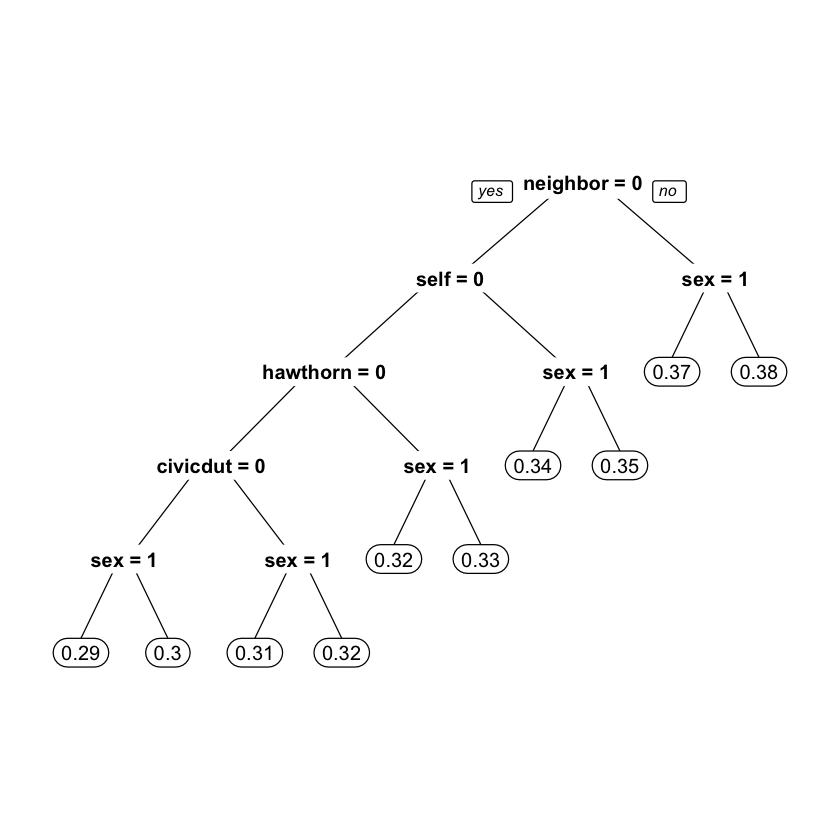

In [282]:
prp(cart_2)

Sex appears to be a secondary consideration when assessing the probability with which an individual is likely to vote. Within each treatment group, women (coded as 1) are 1% less likely to vote than their male counterparts.

### Variable Interaction ###

Logistic models can underperform their CART counterparts for a variety of reasons, one of which is the presence of non-linear variable interaction within the data set.

In [297]:
logit2 = glm(voting ~ sex + control, data=gerber, family=binomial)

In [298]:
summary(logit2)


Call:
glm(formula = voting ~ sex + control, family = binomial, data = gerber)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9220  -0.9012  -0.8290   1.4564   1.5717  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.635538   0.006511 -97.616  < 2e-16 ***
sex         -0.055791   0.007343  -7.597 3.02e-14 ***
control     -0.200142   0.007364 -27.179  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 429238  on 344083  degrees of freedom
Residual deviance: 428443  on 344081  degrees of freedom
AIC: 428449

Number of Fisher Scoring iterations: 4


The negative coefficient accompanying the 'control' variable isn't entirely surprising. The negative coefficient accompanying the 'sex' term suggests females are less likely to vote than males, which agrees with our earlier findings. There is, however, an issue with this formulation: The two variables are evaluated seperately, causing the model to miss the extent to which the variables interact.

Capturing all interactions between two variables can be accomplished in at least two ways. We can create a data set that contains all possible combinations of the two variables. Next, we can use our model to process the data. This yields probabilities for the following sequence of ordered pairs: (Man, Not Control), (Man, Control), (Woman, Not Control), (Woman, Control).

In [286]:
Possibilities = data.frame(sex=c(0,0,1,1),control=c(0,1,0,1))
prediction = predict(logit2, newdata=Possibilities, type="response")
cat(paste(round(prediction,4)*100, "%"))

34.63 % 30.24 % 33.37 % 29.08 %

The alternate approach is more user friendly. We simply add an interaction term with the syntax "variable_1:variable_2" (omit quotes) to our model and run it again, along with all other individual variables, including variables that comprise our interaction term separately. 

In [289]:
logit3 = glm(voting ~ sex + control + sex:control, data=gerber, family="binomial")

In [290]:
summary(logit3)


Call:
glm(formula = voting ~ sex + control + sex:control, family = "binomial", 
    data = gerber)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9213  -0.9019  -0.8284   1.4573   1.5724  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.637471   0.007603 -83.843  < 2e-16 ***
sex         -0.051888   0.010801  -4.804 1.55e-06 ***
control     -0.196553   0.010356 -18.980  < 2e-16 ***
sex:control -0.007259   0.014729  -0.493    0.622    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 429238  on 344083  degrees of freedom
Residual deviance: 428442  on 344080  degrees of freedom
AIC: 428450

Number of Fisher Scoring iterations: 4


In [299]:
predict(logit3, newdata=Possibilities, type="response")

1         2         3         4 
0.3458183 0.3027947 0.3341757 0.2904558

The interaction model predicts a probability of .2904 for the (Women, Control) group, a lower value than our non-interaction model.

The inclusion of the interaction term in the above model allows us to claim that, when examined in isolation, if a subject is a woman in the control group, the probability that she has voted declines. 

The interaction we captured is non-linear. While including all possible combinations of interaction variables is tempting, overfitting could ensure. As we shall see in the next section, non-linear methods like CART easily capture interaction effects. 

#### Interaction Terms in Tree Models ####

We start by examining a CART model based solely on the 'control' group. Next, we will add 'sex' as a variable to this CART model and compare the two. 

In [295]:
cart_3 = rpart(voting ~ control, data=gerber, cp=0.0)

The first tree, shown below, clearly indicates respondents in any of the treatment cohorts are 4.33% more likely to vote than individuals assigned to the control group.

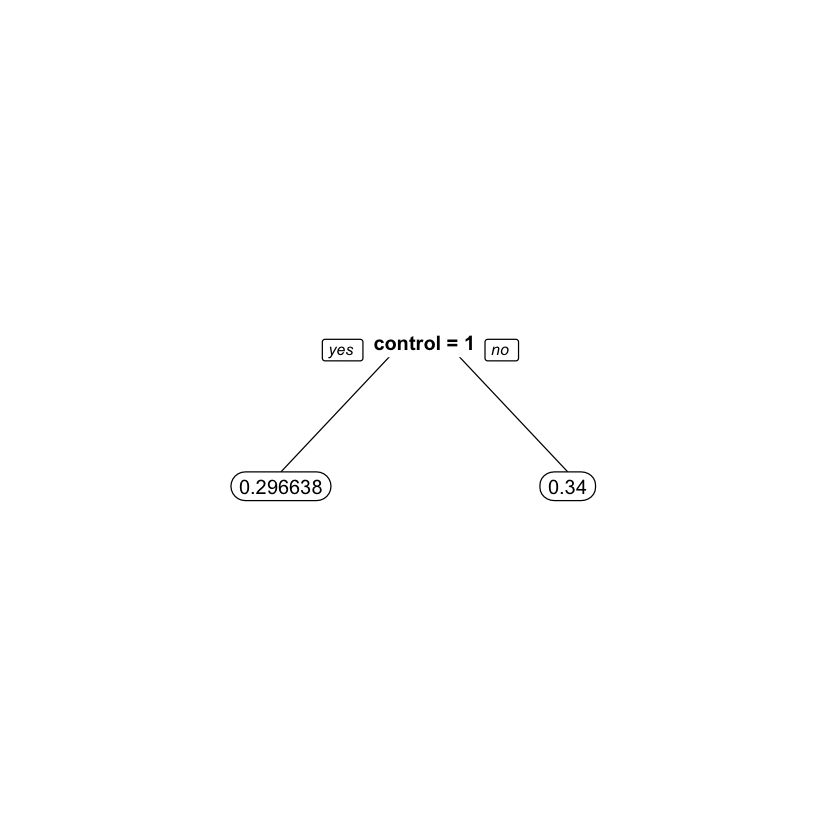

In [296]:
prp(cart_3, digits=6)

In [293]:
cart_4 = rpart(voting ~ control + sex, data=train, cp=0.0)

A cross-comparison of voting probabilities for males and females inside and outside of the control group, as shown in the tree below, reveals that they are affected by approximately the same amount. Thus, being in the control group affects the likelihood one will vote, however, it's effect on males and females relative to their counterparts in treatment groups is about the same.

Note that the interaction effects exhibited by our CART model are, effectively, the same as those we calculated earlier for our logistic model, though capturing this relationship required an economy of effort on our part. For example, the predicted probability for the (Women, Control) group is approximately .2904, which was the value we obtained from our logistic model with an interaction term.

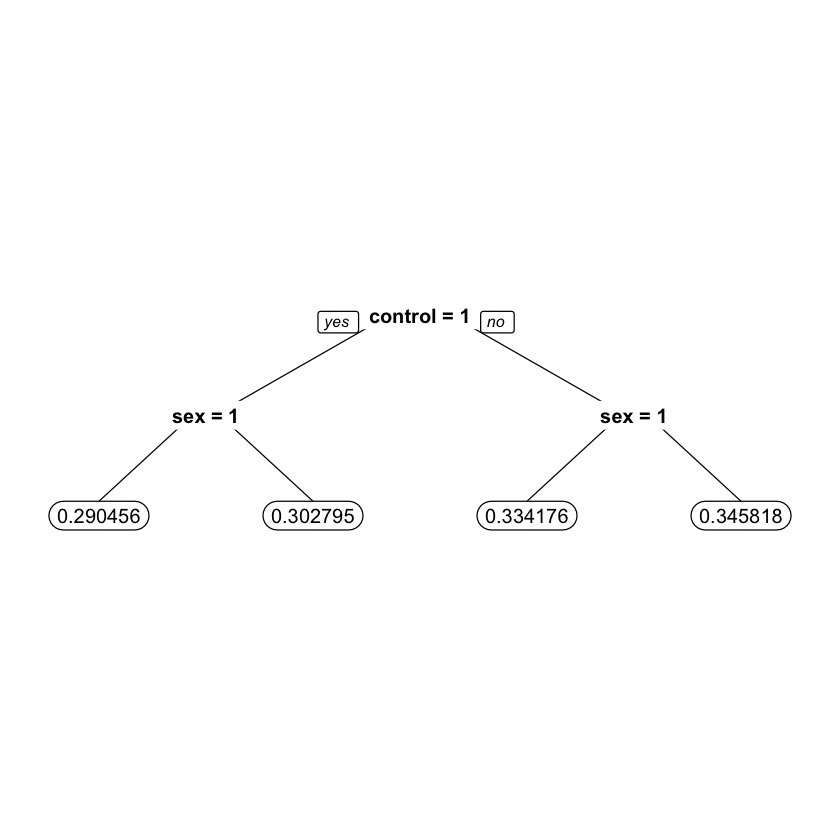

In [294]:
prp(cart_4, digits=6)